# Evaluation for classification

We calculated Accuracy in the last lesson. No we need to find out how much accuracy isch actually good and also discuss other metrics to find out if a model iss good or not. 
* Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

* Evaluate the model on different threshoholds (churn no churn?, we used 0.5 pprobability, above that we say chrun below that we say no churn, but is that threshold any good?)
* Check the accuracy of dummy baselines
* Check if those 80% accuracy are good

In [14]:
#start, end, number_of_values
thresholds = np.linspace(0,1,21)
accuracies = []


for t in thresholds:
    churn_decision = (y_pred >= t)
    accuracy = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t,accuracy))
    accuracies.append(accuracy)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


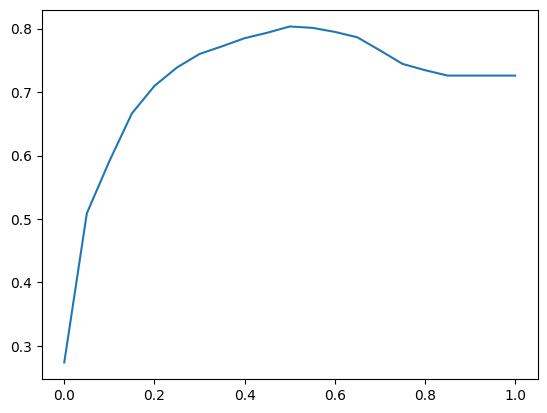

In [15]:
#x axis and 
plt.plot(thresholds,accuracies)

In [17]:
#Sklearn function for accuracy score
from sklearn.metrics import accuracy_score

In [18]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [20]:
#start, end, number_of_values
thresholds = np.linspace(0,1,21)
accuracies = []


for t in thresholds:
    accuracy = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t,accuracy))
    accuracies.append(accuracy)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


Accuracy is not that good with data that has class imbalance. The dummy model is alo quite good. Dummy model means that we put the threshold to 1. Meaning we predict that every customer will not churn. No that we have 73% in the data that actually did not churn, our dummy model has a pretty good performance! and it is only 7% worse in comparison to our calculated model (80%) ---> We need a different metric that is not affected by the class imbalance in our underlying data

## 4.3 Confusion table

* Different types of error and correct decisions
* Arranging them in a a table

In [24]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [25]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [26]:
predict_positive[:5]

array([False, False, False,  True, False])

In [27]:
actual_positive[:5]

array([False, False, False,  True, False])

In [31]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [32]:
confusion_matrix = np.array([[tn,fp],[fn,tp]])

In [33]:
confusion_matrix

array([[922, 101],
       [176, 210]])

The model makes more false negative values than false positives

In [36]:
confusion_matrix/confusion_matrix.sum().round(2)

array([[0.6543648 , 0.07168204],
       [0.12491128, 0.14904187]])

## 4.4 Precision and Recall

With the help of the confusion matrix (tp, tn, fp, fn) we can calculate different metrics for model evaluation. For example accuracy is (tp + tn) / (tp + tn + fp + fn)

Precision: Fraction of positive predictions that are correct
= TP/ (TP + FP). How many of the ones that the model predicted positive are actually positive

In [38]:
p = tp/(tp+fp)
p

0.6752411575562701

Recall: Fraction of correctly identified positive examples. How many of the actual positive did the model predict as positive TP/(FN + TP)

In [41]:
r = tp / (tp + fn)
r

0.5440414507772021

## 4. ROC Curves (Receiving Operator Characterisitics)
* FPR= False Posotove Rate = FP/(FP + TN)
* TPR= True Positive Rate = TP/(FN + TP)

In [42]:
tpr = tp/ (tp + fn)
tpr

0.5440414507772021

In [44]:
fpr = fp/(fp + tn)
fpr

0.09872922776148582

In [49]:
thresholds = np.linspace(0,1, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t,tp,fp,fn, tn))

    

scores

[(0.0, 386, 1023, 0, 0),
 (0.01, 385, 913, 1, 110),
 (0.02, 384, 830, 2, 193),
 (0.03, 383, 766, 3, 257),
 (0.04, 381, 715, 5, 308),
 (0.05, 379, 685, 7, 338),
 (0.06, 377, 661, 9, 362),
 (0.07, 372, 641, 14, 382),
 (0.08, 371, 613, 15, 410),
 (0.09, 369, 580, 17, 443),
 (0.1, 366, 556, 20, 467),
 (0.11, 365, 528, 21, 495),
 (0.12, 365, 509, 21, 514),
 (0.13, 360, 477, 26, 546),
 (0.14, 355, 453, 31, 570),
 (0.15, 351, 435, 35, 588),
 (0.16, 347, 419, 39, 604),
 (0.17, 346, 401, 40, 622),
 (0.18, 344, 384, 42, 639),
 (0.19, 338, 369, 48, 654),
 (0.2, 333, 356, 53, 667),
 (0.21, 330, 341, 56, 682),
 (0.22, 323, 322, 63, 701),
 (0.23, 320, 313, 66, 710),
 (0.24, 316, 304, 70, 719),
 (0.25, 309, 291, 77, 732),
 (0.26, 304, 281, 82, 742),
 (0.27, 303, 270, 83, 753),
 (0.28, 295, 256, 91, 767),
 (0.29, 291, 244, 95, 779),
 (0.3, 284, 236, 102, 787),
 (0.31, 280, 230, 106, 793),
 (0.32, 278, 226, 108, 797),
 (0.33, 276, 221, 110, 802),
 (0.34, 274, 212, 112, 811),
 (0.35000000000000003, 272,

In [53]:
columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores= df_scores[::10]
df_scores['tpr'] = df_scores.tp/(df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp/(df_scores.fp + df_scores.tn)

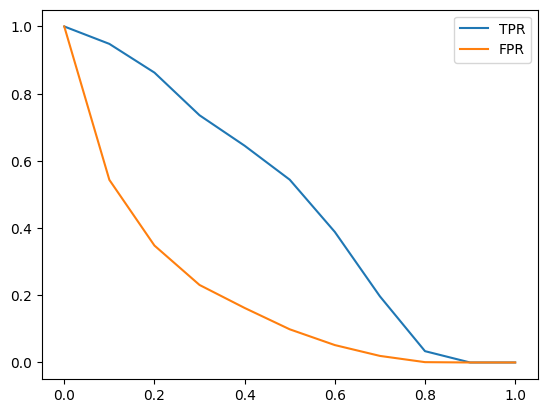

In [56]:
plt.plot(df_scores.thresholds, df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.thresholds, df_scores['fpr'], label = 'FPR')
plt.legend()


### Random Model

In [57]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size=len(y_val))
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [59]:
from sklearn.metrics import roc_curve

In [60]:
fpr, tpr, thresholds  = roc_curve(y_val, y_pred)

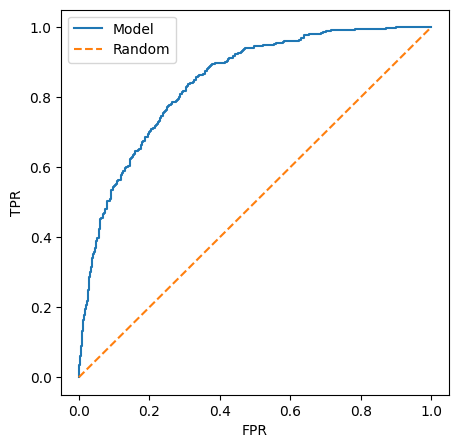

In [62]:
plt.figure(figsize=(5,5))

plt.plot(fpr,tpr, label = 'Model')
plt.plot([0,1], [0,1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 Area under the ROC Curve

In [63]:
from sklearn.metrics import auc

In [65]:
auc(fpr, tpr)

0.843850505725819

In [66]:
fpr, tpr, thresholds  = roc_curve(y_val, y_pred)
auc(df_scores.fpr, df_scores.tpr)

0.8339423822041238

In [67]:
#Shortcut:

from sklearn.metrics import roc_auc_score

In [68]:
roc_auc_score(y_val, y_pred)

0.843850505725819

AUC = Probability that randomly slected positive example has a higher score than a randomly selected negative example

In [69]:

from hashlib import sha1

def compute_hash(email):
    return sha1(email.lower().encode('utf-8')).hexdigest()


compute_hash('konstantinos.lessis@gmail.com')

'6531e00083019aef56cb25b82da1654de7cd6c89'